# OpenVINO example with Squeezenet Model

This notebook illustrates how you can serve [OpenVINO](https://software.intel.com/en-us/openvino-toolkit) optimized models for Imagenet with Seldon Core.

<img src="dog.jpeg"/>

## Dependencies

 * Seldon-core (```pip install seldon-core```)
 * Numpy
 * Keras
 * Matplotlib
 * Tensorflow

## Download Squeezenet Model

We will download a pre-trained and optimized model for OpenVINO CPU into a local folder.

In [ ]:
!mkdir -p models/squeezenet/1 && \
    wget -O models/squeezenet/1/squeezenet1.1.xml https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.xml && \
    wget -O models/squeezenet/1/squeezenet1.1.mapping https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.mapping && \
    wget -O models/squeezenet/1/squeezenet1.1.bin https://s3-eu-west-1.amazonaws.com/seldon-public/openvino-squeeznet-model/squeezenet1.1.bin 

## Run Seldon Core on Minikube

**The example below assumes Minikube 0.30.0 installed**

In [ ]:
!minikube start --memory 4096 --disk-size 20g --extra-config=apiserver.authorization-mode=RBAC

In [1]:
!kubectl create namespace seldon

namespace/seldon created


In [2]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [3]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [4]:
!helm init

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [5]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for deployment "tiller-deploy" rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [7]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd  --set usage_metrics.enabled=true
!helm install ../../../helm-charts/seldon-core --name seldon-core --set ambassador.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Sat Dec 22 09:59:12 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        1        1           0          0s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        0s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1/Pod(related)
NAME                                         READY  STATUS             RESTARTS  AGE
seldon-spartakus-volunteer-7d9895b6fb-529gz  0/1    ContainerCreating  0         0s

==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     0s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  0s


NOTES:
NOTES: TODO



## (Optional) Install Jaeger

We will use the Jaeger All-in-1 resource found at the [Jaeger Kubernetes repo](https://github.com/jaegertracing/jaeger-kubernetes).

In [ ]:
!kubectl create -f https://raw.githubusercontent.com/jaegertracing/jaeger-kubernetes/master/all-in-one/jaeger-all-in-one-template.yml -n seldon

### Start Jaeger UI

```
minikube service jaeger-query -n seldon
```

## Mount local folder onto minikube for HostPath
Run in the current folder:
```
minikube mount ./models:/opt/ml
```

This will allow the model folder containing the Squeezenet model to be accessed. For production deployments you would use a NFS volume.

## Build Combiner Image

In [8]:
!eval $(minikube docker-env) && cd resources/combiner && s2i build -E environment_grpc . seldonio/seldon-core-s2i-python36:0.5-SNAPSHOT seldonio/imagenet_combiner:0.1

---> Installing application source...
Build completed successfully


In [9]:
!eval $(minikube docker-env) && cd resources/transformer && s2i build -E environment_grpc . seldonio/seldon-core-s2i-python36:0.5-SNAPSHOT seldonio/imagenet_transformer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
Running setup.py bdist_wheel for pyyaml: started
Running setup.py bdist_wheel for pyyaml: finished with status 'done'
Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
Build completed successfully


## Deploy Seldon Intel OpenVINO Graph

In [10]:
import sys
sys.path.append("../../../notebooks")
from visualizer import *

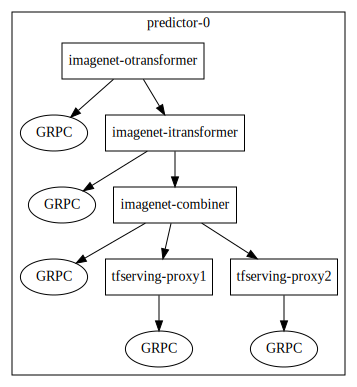

In [11]:
get_graph("seldon_openvino_ensemble.json")

In [13]:
!pygmentize seldon_openvino_ensemble.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "openvino-model",
	"namespace": "seldon"	
    },
    "spec": {
        "name": "openvino",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "name": "imagenet-itransformer",				
                                "image": "seldonio/imagenet_transformer:0.1",
				"env": [
				    {
					"name": "TRACING",
					"value": "1"
				    },
				    {
					"name": "JAEGER_AGENT_HOST",
					"value": "jaeger-agent"
				    }
				]
                            },
                            {
                                "name": "imagenet-otransformer",				
                                "image": "seldonio/imagenet_transformer:0.1",
				"env": [
				    {
					"na

In [14]:
!kubectl apply -f pvc.json
!kubectl apply -f seldon_openvino_ensemble.json

persistentvolume/hostpath-pvc created
persistentvolumeclaim/model-store-pvc created
seldondeployment.machinelearning.seldon.io/openvino-model created


# Serve Requests

**Ensure you port forward ambassador:**

```
kubectl port-forward $(kubectl get pods -n seldon -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

In [15]:
import tensorflow as tf
from seldon_core.proto import prediction_pb2
from seldon_core.proto import prediction_pb2_grpc
import grpc

def grpc_request_ambassador(deploymentName,namespace,endpoint="localhost:8004",data=None):
    datadef = prediction_pb2.DefaultData(
                names = 'x',
                tftensor = tf.make_tensor_proto(data)
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(endpoint)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    if namespace is None:
        metadata = [('seldon',deploymentName)]
    else:
        metadata = [('seldon',deploymentName),('namespace',namespace)]
    response = stub.Predict(request=request,metadata=metadata)
    return response


(227, 227, 3)
129.07299999999998
Eskimo dog, husky


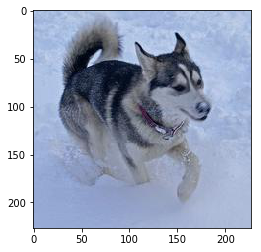

In [30]:
%matplotlib inline
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import sys
import json
import matplotlib.pyplot as plt
import datetime
API_AMBASSADOR="localhost:8003"

def getImage(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x/255.)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def getImageRaw(path):
    img = image.load_img(path, target_size=(227, 227))
    x = image.img_to_array(img)
    plt.imshow(x/255.)
    return x

#X = getImage("car.png")
#X = X.transpose((0,3,1,2))

#X = getImageRaw("car.png")
X = getImageRaw("dog.jpeg")
print(X.shape)
start_time = datetime.datetime.now()
response = grpc_request_ambassador("openvino-model","seldon",API_AMBASSADOR,data=X)
end_time = datetime.datetime.now()
duration = (end_time - start_time).total_seconds() * 1000
print(duration)

print(response.strData)

#result = tf.make_ndarray(response.data.tftensor)   
#result = result.reshape(1,1000)

#with open('imagenet_classes.json') as f:
#    cnames = eval(f.read())
#
#    single_result = result[[0],...]
#    ma = np.argmax(single_result)
#    print("\t",0, cnames[ma])
